# Computational astrophysics
# HW 2

In [1]:
# libraries imported 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy import units as u

%matplotlib widget
plt.style.use('/Users/dionysisgakis/.config/matplotlib/stylelib/publication.mplstyle') # plotting style, comment out if in another computer

In [2]:
# Constants
G = 6.6743e-11 * u.m**3 / (u.kg * u.s**2)  # Gravitational constant
M_sun = 1.9885e30 * u.kg  # Solar mass
AU = 1.496e11 * u.m  # Astronomical unit
year = 365.25 * 86400 * u.s  # seconds in a year
day = 86400 * u.s  # seconds in a day

a = 1 * AU  # Semi-major axis

### Fixed timestep

In [3]:
def rk4(timespan, timestep_fraction, eccentricity):
    """
    Simulates the orbit of a body around the Sun using the 4th order Runge-Kutta method.
    
    Parameters:
    timespan (float): The total time for the simulation in years.
    timestep_fraction (float): The fraction of the total time used as the timestep.
    eccentricity (float): The eccentricity of the orbit.
    
    Returns:
    tuple: (pos, vel) arrays containing the positions and velocities of the body at each timestep.
    float: normalized energy of the body at each timestep.
    """
    
    # Orbital parameters
    e = eccentricity  # Eccentricity
    r_p = a * (1 - e)  # Periapsis
    u_p = np.sqrt(G * M_sun / a) * np.sqrt((1. + e) / (1. - e))  # Pericenter velocity
    
    # Time settings
    T = timespan * year  # Total timespan in seconds
    dt = (T * timestep_fraction).to(u.s).value  # Timestep
    N = int((T / dt).decompose().value) + 1 # Number of steps
    
    # Position and velocity arrays
    pos = np.zeros((N, 2))  # 2D position array (x, y)
    vel = np.zeros((N, 2))  # 2D velocity array (vx, vy)

    r = np.zeros(N)  # Distance magnitude
    v = np.zeros(N)  # Velocity magnitude
    
    # Initial conditions
    pos[0] = [0, r_p.to(u.m).value]  # (0, r_p)
    vel[0] = [-u_p.to(u.m / u.s).value, 0]  # (-u_p, 0)

    # Normalized energies
    def kinetic_energy(v):
        return 0.5 * v**2

    def potential_energy(r):
        return -G.value * M_sun.value / r

    def total_energy(r, v):
        return kinetic_energy(v) + potential_energy(r)
    
    kinetic = np.zeros(N)
    potential = np.zeros(N)
    total_ene = np.zeros(N)

    times = np.linspace(0, T.to(u.s).value, N)
    
    # Acceleration function
    def acceleration(pos):
        r = np.sqrt(pos[0]**2 + pos[1]**2)
        return -G.value * M_sun.value / r**3 * pos
    
    # Runge-Kutta 4th order method
    for i in range(N-1):
        k1_v = dt * acceleration(pos[i])
        k1_r = dt * vel[i]

        k2_v = dt * acceleration(pos[i] + 0.5 * k1_r)
        k2_r = dt * (vel[i] + 0.5 * k1_v)

        k3_v = dt * acceleration(pos[i] + 0.5 * k2_r)
        k3_r = dt * (vel[i] + 0.5 * k2_v)

        k4_v = dt * acceleration(pos[i] + k3_r)
        k4_r = dt * (vel[i] + k3_v)

        vel[i+1] = vel[i] + (k1_v + 2. * k2_v + 2. * k3_v + k4_v) / 6.
        pos[i+1] = pos[i] + (k1_r + 2. * k2_r + 2. * k3_r + k4_r) / 6.

        r[i] = np.sqrt(pos[i, 0]**2 + pos[i, 1]**2)
        v[i] = np.sqrt(vel[i, 0]**2 + vel[i, 1]**2)
        
        kinetic[i+1] = kinetic_energy(v[i])
        potential[i+1] = potential_energy(r[i])
        total_ene[i+1] = total_energy(r[i], v[i])

    # Plot orbit
    fig, ax = plt.subplots()
    ax.plot(pos[:, 0] / AU, pos[:, 1] / AU, color = 'blue')
    ax.scatter(pos[:, 0] / AU, pos[:, 1] / AU, color = 'blue', s=10, label='Earth')
    ax.set_xlabel('x (AU)')
    ax.set_ylabel('y (AU)')
    plt.scatter(0, 0, color='yellow', s=100, label='Sun')  
    plt.axis('equal')
    plt.legend()
    plt.show()
    
    # Plot energies
    fig, ax = plt.subplots()
    ax.set_title('Normalized energies')
    #ax.plot(times / day, kinetic, label='Kinetic Energy')
    #ax.plot(times / day, potential, label='Potential Energy')
    ax.plot(times / day, total_ene, label='Total Energy')
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Energy (J/kg)')
    plt.legend()
    plt.show()
    
    return pos, vel, total_ene


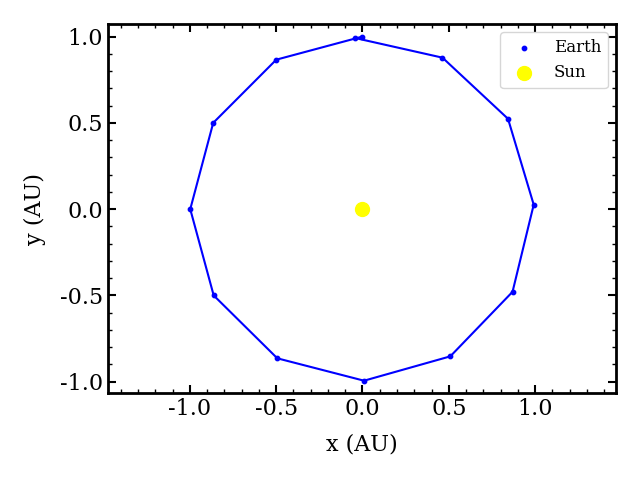

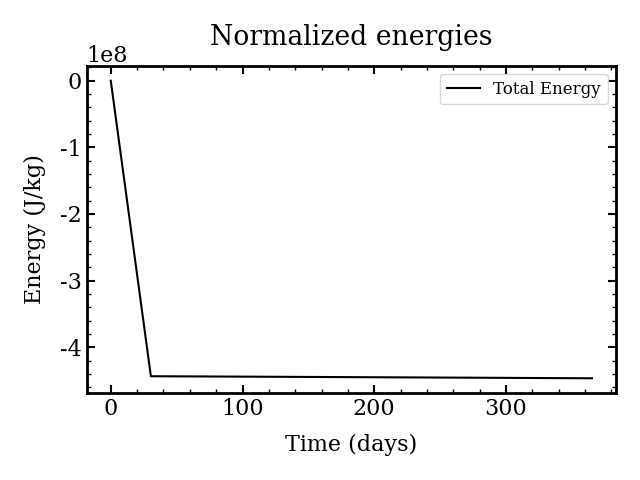

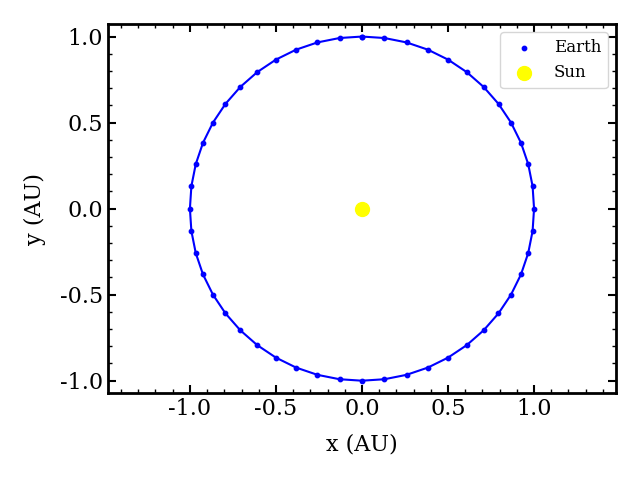

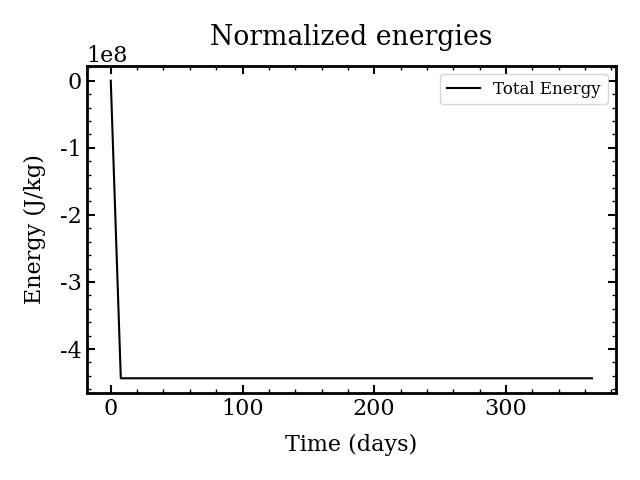

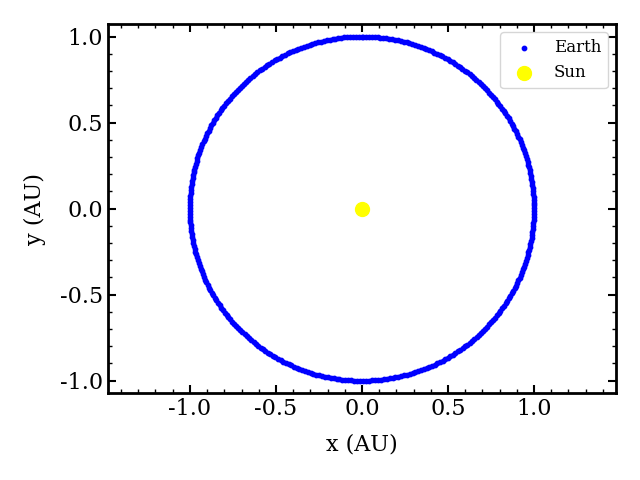

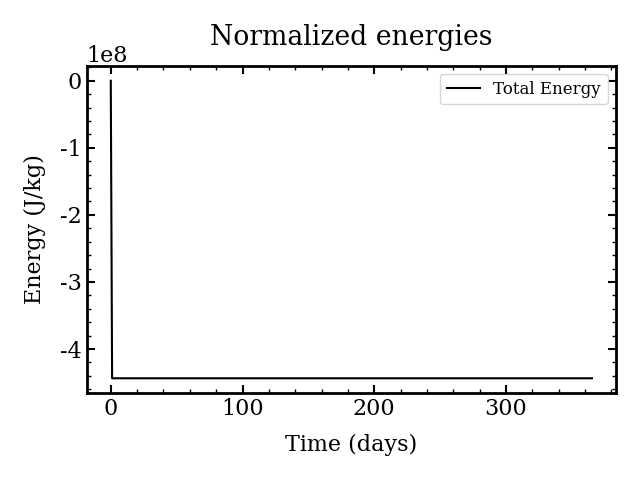

Position error:
Timestep 1/12: 0.044579347429602685 AU
Timestep 1/48: 3.8197069525318296e-05 AU
Timestep 1/365.25: 0.00441094029931217 AU


Energy error:
Timestep 1/12: 446641851.0219316 J
Timestep 1/48: 443580648.9977768 J
Timestep 1/365.25: 443577725.71782595 J


In [4]:
# e = 0
pos1, vel1, energy1 = rk4(timespan=1, timestep_fraction=1/12, eccentricity=0.0) 
pos2, vel2, energy2 = rk4(timespan=1, timestep_fraction=1/48, eccentricity=0.0) 
pos3, vel3, energy3 = rk4(timespan=1, timestep_fraction=1/365.25, eccentricity=0.0) 

error_pos1 = np.sqrt((pos1[-1, 0] - pos1[0, 0])**2 + (pos1[-1, 1] - pos1[0, 1])**2 + (pos1[-1, 1] - pos1[0, 1])**2) / AU.value * u.AU
error_pos2 = np.sqrt((pos2[-1, 0] - pos2[0, 0])**2 + (pos2[-1, 1] - pos2[0, 1])**2 + (pos2[-1, 1] - pos2[0, 1])**2) / AU.value * u.AU
error_pos3 = np.sqrt((pos3[-1, 0] - pos3[0, 0])**2 + (pos3[-1, 1] - pos3[0, 1])**2 + (pos3[-1, 1] - pos3[0, 1])**2) / AU.value * u.AU

error_energy1 = np.abs(energy1[-1] - energy1[0]) * u.J
error_energy2 = np.abs(energy2[-1] - energy2[0]) * u.J
error_energy3 = np.abs(energy3[-1] - energy3[0]) * u.J

print("Position error:")
print(f"Timestep 1/12: {error_pos1}")
print(f"Timestep 1/48: {error_pos2}")
print(f"Timestep 1/365.25: {error_pos3}")
print("\n")
print("Energy error:")
print(f"Timestep 1/12: {error_energy1}")
print(f"Timestep 1/48: {error_energy2}")
print(f"Timestep 1/365.25: {error_energy3}")

For a circular orbit, the error in the final position decreases as the timestep is reduced. With a timestep of 1 month, the error is relatively large, as the trajectory deviates more from the true path over time. With a timestep of 1 week, the error is smaller but still noticeable. Using a 1-day timestep, the error becomes significantly smaller, showing better accuracy. Also, as we're moving to smaller timesteps, the shape of the orbit changes to more circular from a polygon.

For energy conservation, the code is still not doing great even when reducing the timestep, since I don't get quite different energy evolutions for different timesteps. This is indicative of the unsuitability of the numerical scheme we use for this type of integrations.

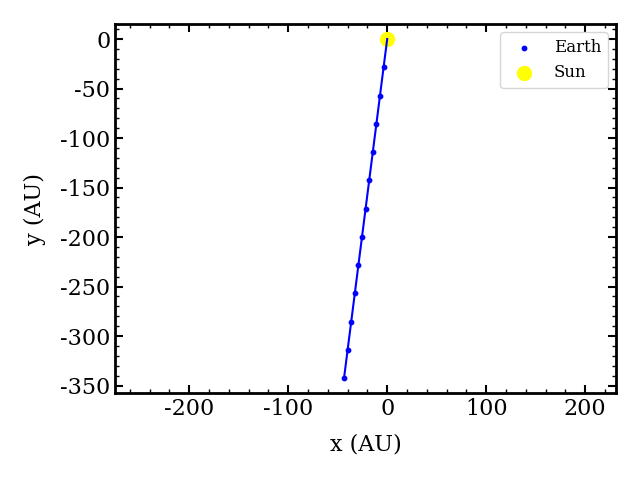

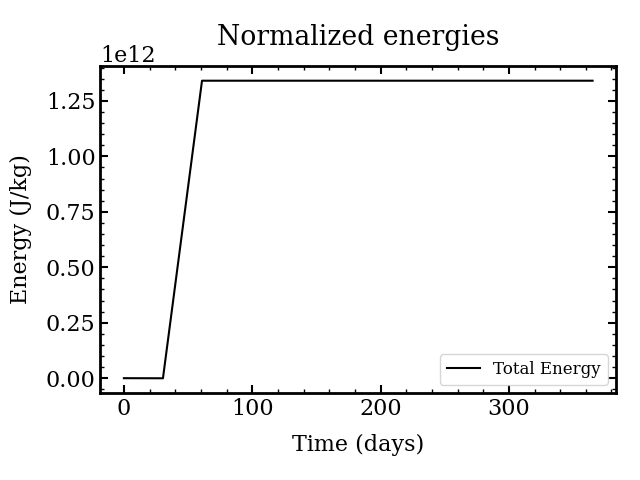

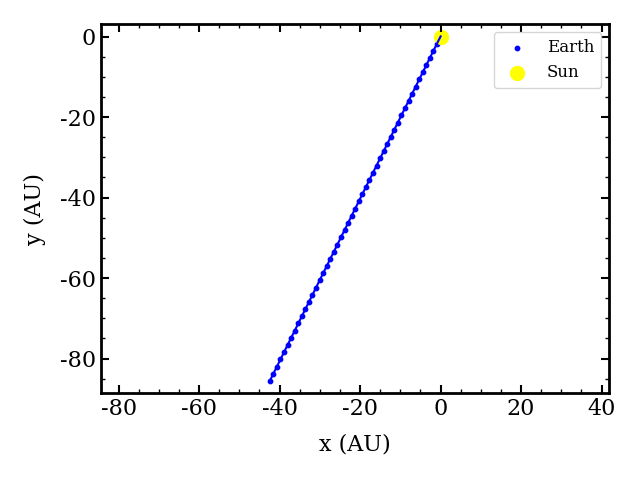

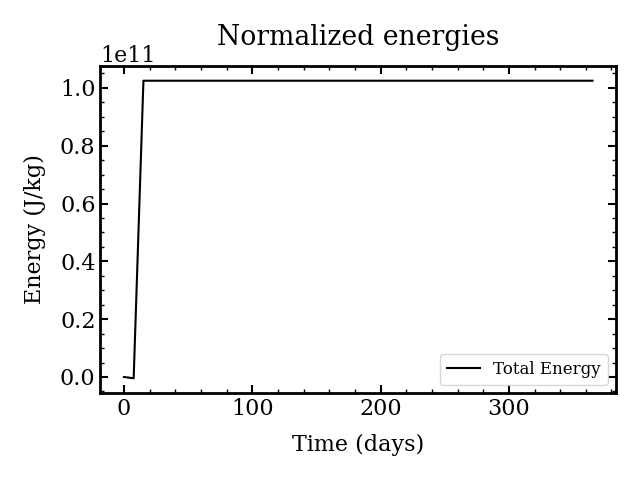

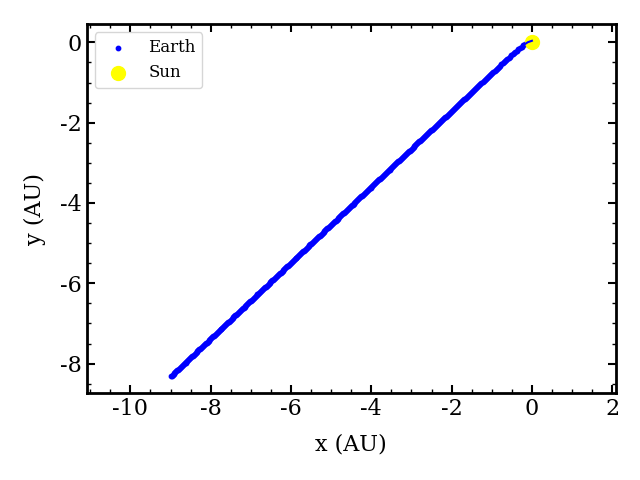

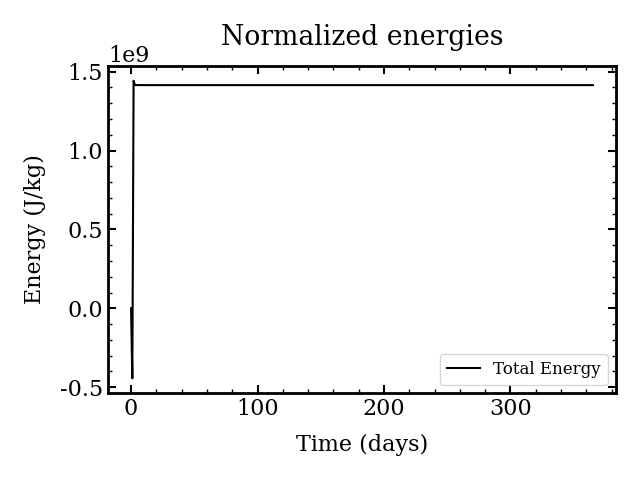

Position error:
Timestep 1/12: 486.5917514736206 AU
Timestep 1/48: 128.2562909770576 AU
Timestep 1/365.25: 14.854876570117895 AU


Energy error:
Timestep 1/12: 1340895303995.7957 J
Timestep 1/48: 102474703786.44017 J
Timestep 1/365.25: 1414558258.8212595 J


In [5]:
# e = 0.96
pos1_e, vel1_e, energy1_e = rk4(timespan=1, timestep_fraction=1/12, eccentricity=0.96) 
pos2_e, vel2_e, energy2_e = rk4(timespan=1, timestep_fraction=1/48, eccentricity=0.96) 
pos3_e, vel3_e, energy3_e = rk4(timespan=1, timestep_fraction=1/365.25, eccentricity=0.96) 

error_pos1_e = np.sqrt((pos1_e[-1, 0] - pos1_e[0, 0])**2 + (pos1_e[-1, 1] - pos1_e[0, 1])**2 + (pos1_e[-1, 1] - pos1_e[0, 1])**2) / AU.value * u.AU
error_pos2_e = np.sqrt((pos2_e[-1, 0] - pos2_e[0, 0])**2 + (pos2_e[-1, 1] - pos2_e[0, 1])**2 + (pos2_e[-1, 1] - pos2_e[0, 1])**2) / AU.value * u.AU
error_pos3_e = np.sqrt((pos3_e[-1, 0] - pos3_e[0, 0])**2 + (pos3_e[-1, 1] - pos3_e[0, 1])**2 + (pos3_e[-1, 1] - pos3_e[0, 1])**2) / AU.value * u.AU

error_energy1_e = np.abs(energy1_e[-1] - energy1_e[0]) * u.J
error_energy2_e = np.abs(energy2_e[-1] - energy2_e[0]) * u.J
error_energy3_e = np.abs(energy3_e[-1] - energy3_e[0]) * u.J

print("Position error:")
print(f"Timestep 1/12: {error_pos1_e}")
print(f"Timestep 1/48: {error_pos2_e}")
print(f"Timestep 1/365.25: {error_pos3_e}")
print("\n")
print("Energy error:")
print(f"Timestep 1/12: {error_energy1_e}")
print(f"Timestep 1/48: {error_energy2_e}")
print(f"Timestep 1/365.25: {error_energy3_e}")

As a general comment, the orbit does not have the shape of an ellipse (of high eccentrricity), but rather is a straight line, which suggests that this numerical scheme is not suitable. Reducing the timestep does not improve the shape, but only ameliorates the x, y values, being closer to the expected ones. Regarding the error in mechanical energy, it does get smaller with smaller timesteps, but still is quite large in all cases.

### Adaptive timestep

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

def rk4_adaptive(timespan, timestep_fraction):
    """
    Simulates the orbit of a body around the Sun using the 4th order Runge-Kutta method with adaptive timestep.
    
    Parameters:
    timespan (float): The total time for the simulation in years.
    timestep_fraction (float): The fraction of the total time used as the initial timestep.
    
    Returns:
    tuple: (pos, vel) arrays containing the positions and velocities of the body at each timestep.
    float: normalized energy of the body at each timestep.
    int: the number of time steps taken.
    """
    
    # Orbital parameters
    e = 0.96  # Eccentricity
    r_p = a * (1 - e)  # Periapsis
    u_p = np.sqrt(G * M_sun / a) * np.sqrt((1. + e) / (1. - e))  # Pericenter velocity
    
    # Time settings
    T = timespan * year  # Total timespan in seconds
    dt = (T * timestep_fraction).to(u.s).value  # Initial timestep
    t = 0  # Initialize time
    
    # Arrays
    pos_list = []
    vel_list = []
    energy_list = []
    kinetic_energy_list = []
    potential_energy_list = []
    time_list = []
    timestep_list = []
    
    # Initial conditions
    pos = np.array([0, r_p.to(u.m).value])  # (0, r_p)
    vel = np.array([-u_p.to(u.m / u.s).value, 0])  # (-u_p, 0)

    e_goal = 1e-5
    num_steps = 0

    # Normalized energies
    def kinetic_energy(v):
        return 0.5 * v**2

    def potential_energy(r):
        return -G.value * M_sun.value / r

    def total_energy(r, v):
        return kinetic_energy(v) + potential_energy(r)
    
    # Acceleration function
    def acceleration(pos):
        r = np.sqrt(pos[0]**2 + pos[1]**2)
        return -G.value * M_sun.value / r**3 * pos
    
    while t < T.to(u.s).value:
        num_steps += 1  # Count step
        
        # Compute single RK4 step with dt (yτ)
        k1_v = dt * acceleration(pos)
        k1_r = dt * vel
        
        k2_v = dt * acceleration(pos + 0.5 * k1_r)
        k2_r = dt * (vel + 0.5 * k1_v)
        
        k3_v = dt * acceleration(pos + 0.5 * k2_r)
        k3_r = dt * (vel + 0.5 * k2_v)
        
        k4_v = dt * acceleration(pos + k3_r)
        k4_r = dt * (vel + k3_v)
        
        pos_dt = pos + (k1_r + 2 * k2_r + 2 * k3_r + k4_r) / 6.0
        vel_dt = vel + (k1_v + 2 * k2_v + 2 * k3_v + k4_v) / 6.0
        
        # Compute two RK4 steps with dt/2 (y2(τ/2))
        dt_half = dt / 2.0
        
        k1_v_half = dt_half * acceleration(pos)
        k1_r_half = dt_half * vel
        
        k2_v_half = dt_half * acceleration(pos + 0.5 * k1_r_half)
        k2_r_half = dt_half * (vel + 0.5 * k1_v_half)
        
        k3_v_half = dt_half * acceleration(pos + 0.5 * k2_r_half)
        k3_r_half = dt_half * (vel + 0.5 * k2_v_half)
        
        k4_v_half = dt_half * acceleration(pos + k3_r_half)
        k4_r_half = dt_half * (vel + k3_v_half)
        
        pos_half = pos + (k1_r_half + 2 * k2_r_half + 2 * k3_r_half + k4_r_half) / 6.0
        vel_half = vel + (k1_v_half + 2 * k2_v_half + 2 * k3_v_half + k4_v_half) / 6.0
        
        # Second step of dt/2
        k1_v_half = dt_half * acceleration(pos_half)
        k1_r_half = dt_half * vel_half
        
        k2_v_half = dt_half * acceleration(pos_half + 0.5 * k1_r_half)
        k2_r_half = dt_half * (vel_half + 0.5 * k1_v_half)
        
        k3_v_half = dt_half * acceleration(pos_half + 0.5 * k2_r_half)
        k3_r_half = dt_half * (vel_half + 0.5 * k2_v_half)
        
        k4_v_half = dt_half * acceleration(pos_half + k3_r_half)
        k4_r_half = dt_half * (vel_half + k3_v_half)
        
        pos_2dt = pos_half + (k1_r_half + 2 * k2_r_half + 2 * k3_r_half + k4_r_half) / 6.0
        vel_2dt = vel_half + (k1_v_half + 2 * k2_v_half + 2 * k3_v_half + k4_v_half) / 6.0
        
        # Compute relative error
        e_rel = abs(1 - (np.sqrt(pos_dt[0]**2 + pos_dt[1]**2) / np.sqrt(pos_2dt[0]**2 + pos_2dt[1]**2)))
        dt_est = dt * (e_goal / e_rel) ** (1.0 / 5.0)
        
        if e_rel <= e_goal:
            # Accept step and update
            pos = pos_2dt
            vel = vel_2dt
            t += dt
            dt = dt_est  # Adjust timestep
            pos_list.append(pos)
            vel_list.append(vel)
            kinetic_energy_list.append(kinetic_energy(np.linalg.norm(vel)))
            potential_energy_list.append(potential_energy(np.linalg.norm(pos)))
            energy_list.append(total_energy(np.linalg.norm(pos), np.linalg.norm(vel)))
            time_list.append(t)
            timestep_list.append(dt)
        else:
            # Reject step and retry with smaller timestep
            dt = dt_est
    
    pos_arr = np.array(pos_list)
    vel_arr = np.array(vel_list)
    energy_arr = np.array(energy_list)
    kinetic_arr = np.array(kinetic_energy_list)
    potential_arr = np.array(potential_energy_list)
    time_arr = np.array(time_list)
    timestep_arr = np.array(timestep_list)

    # Plot orbit
    fig, ax = plt.subplots()
    ax.plot(pos_arr[:, 0] / AU, pos_arr[:, 1] / AU, color='blue')
    ax.scatter(pos_arr[:, 0] / AU, pos_arr[:, 1] / AU, color='blue', label='Earth')
    ax.set_xlabel('x (AU)')
    ax.set_ylabel('y (AU)')
    plt.scatter(0, 0, color='yellow', s=100, label='Sun')  
    plt.axis('equal')
    plt.legend()
    plt.show()
    
    # Plot energies
    fig, ax = plt.subplots()
    ax.set_title('Normalized energies')
    #ax.semilogy(time_arr / day.value, kinetic_arr, label='Kinetic Energy')
    #ax.semilogy(time_arr / day.value, potential_arr, label='Potential Energy')
    ax.plot(time_arr / day.value, energy_arr, label='Total Energy')
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Energy (J/kg)')
    plt.legend()
    plt.show()
    
    # Plot timestep evolution
    plt.figure()
    plt.plot(time_arr / day.value, timestep_arr / day.value, color='red')
    plt.scatter(time_arr / day.value, timestep_arr / day.value, color='red')
    plt.xlabel('Time (days)')
    plt.ylabel('Timestep (days)')
    plt.title('Evolution of Timestep')
    plt.show()
    
    return pos_arr, vel_arr, energy_arr, num_steps

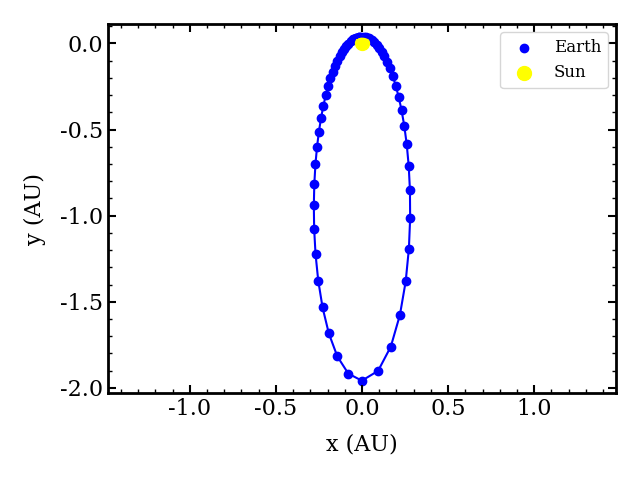

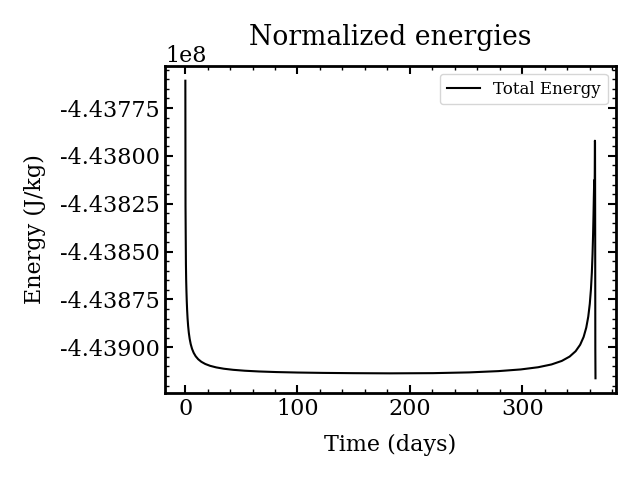

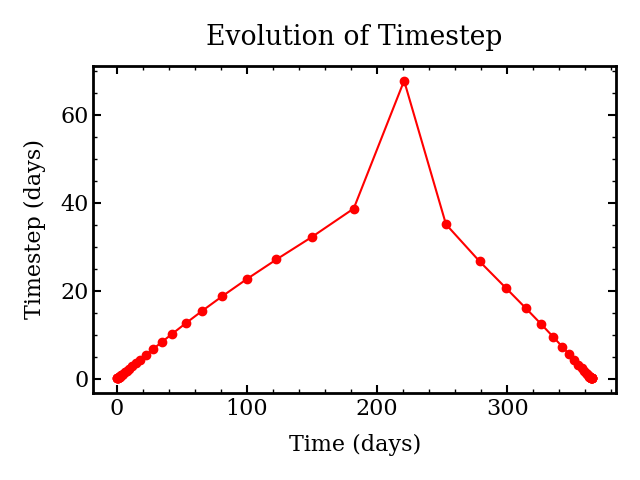

Results for 1 orbit:
Number of timesteps taken: 127


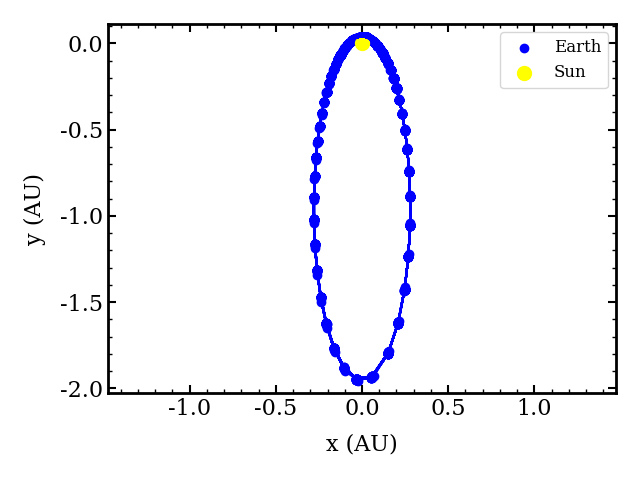

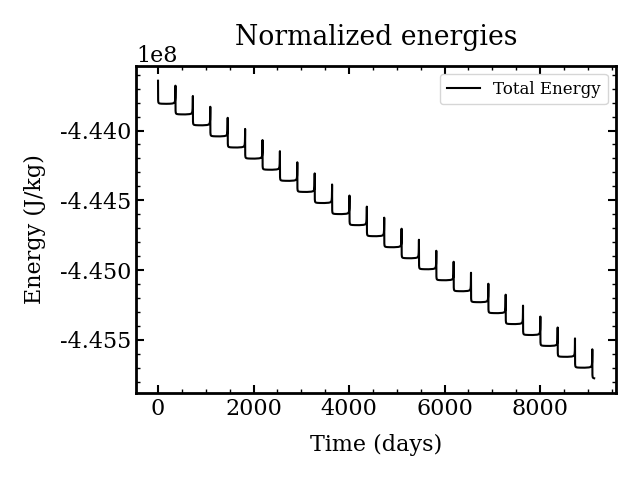

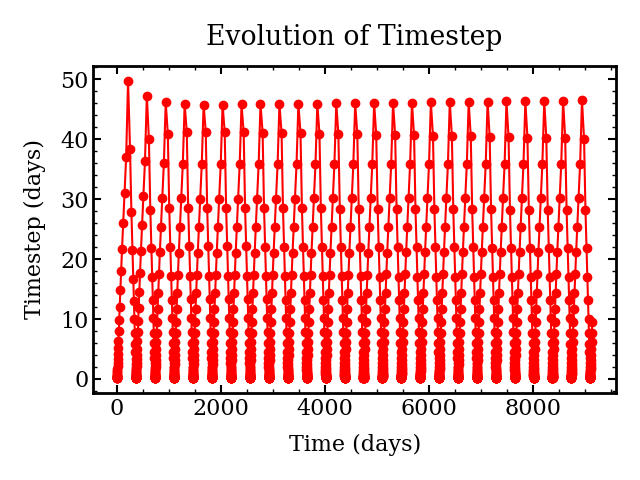

Results for 25 orbits:
Number of timesteps taken: 2692


In [7]:
# 1 orbit (1 year) with an initial timestep of one month
pos1_e, vel1_e, energy1_e, num_steps1 = rk4_adaptive(timespan=1, timestep_fraction=1/12)

# Print results for 1 orbit
print("Results for 1 orbit:")
print(f"Number of timesteps taken: {num_steps1}")

# 25 orbits (25 years) with an initial timestep of one month
pos25_e, vel25_e, energy25_e, num_steps25 = rk4_adaptive(timespan=25, timestep_fraction=1/12)

# Print results for 25 orbits
print("Results for 25 orbits:")
print(f"Number of timesteps taken: {num_steps25}")

As expected, the code does a better job in calculating the energy near the pericenter position (which is the initial condition), and gets worse away from it. Hence, the energy error (energy at a specific timestep minus original energy) roughly oscillates within a period, between a minimum and a maximum. However, as we can see from the 25 orbits' evolution, the energy error nonetheless increases over time in a longer timescale, apart from the short-term oscillatory character it has. Energy conservation is critical for these type of problems studying the orbital architecture of systems over a long period of time. Hence, RK4 method is definitely not suitable for doing accurate planetary orbit calculations over a long period of time, particularly as long as the age of the Solar System. Other techniques, such as the leapfrog scheme, are most suited for these objectives.